# Training and Evaluating Xception Model

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
models = tf.contrib.keras.models
layers = tf.contrib.keras.layers
utils = tf.contrib.keras.utils
losses = tf.contrib.keras.losses
optimizers = tf.contrib.keras.optimizers 
metrics = tf.contrib.keras.metrics
preprocessing_image = tf.contrib.keras.preprocessing.image
applications = tf.contrib.keras.applications

In [4]:
# load pre-trained Xception model and exclude top dense layer
base_model = applications.Xception(include_top=False,
                                   weights='imagenet',
                                   input_shape=(299,299,3),
                                   pooling='avg')

83410944/83683744 [============================>.] - ETA: 0s

In [5]:
print("Model input shape: {}\n".format(base_model.input_shape))
print("Model output shape: {}\n".format(base_model.output_shape))
print("Model number of layers: {}\n".format(len(base_model.layers)))

Model input shape: (None, 299, 299, 3)

Model output shape: (None, 2048)

Model number of layers: 133



# Fine-tune Xception Model

##  freeze weights of early layers to ease training (Important !!!)

In [7]:
def fine_tune_Xception(base_model):
     
    # output of convolutional layers
    x = base_model.output

    # final Dense layer
    # 4 output classes
    outputs = layers.Dense(4, activation='softmax')(x)

    # define model with base_model's input
    model = models.Model(inputs=base_model.input, outputs=outputs)
    
    # freeze weights of early layers
    # to ease training
    for layer in model.layers[:40]:
        layer.trainable = False
    
    return model

# Compile Model

In [8]:
def compile_model(model):
    # loss + optmizer +accuracy
    loss = losses.categorical_crossentropy
    optimizer = optimizers.RMSprop(lr=0.0001)
    metric = [metrics.categorical_accuracy]

    # compile model 
    model.compile(optimizer, loss, metric)
        
    return model

# Inspect Model Architecture

In [10]:
model = fine_tune_Xception(base_model)
model = compile_model(model)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 149, 149, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 149, 149, 32)  128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 149, 149, 32)  0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

# Image Preprocessing

In [11]:
def preprocess_image(x):
    # make sure to do the calculations with floats
    x /= 255.0 # normalization
    x -= 0.5
    x *= 2.0
    
    # 'RGB'->'BGR'
    x = x[..., ::-1]
    # Zero-center by mean pixel
    x[..., 0] -= 103.939
    x[..., 1] -= 116.779
    x[..., 2] -= 123.68
    return x


train_datagen = preprocessing_image.ImageDataGenerator(
    preprocessing_function=preprocess_image, # function that will be implied on each input, will run before any other modification on it
    shear_range=0.2, # data augmentation
    zoom_range=0.2,  # data augmentation
    horizontal_flip=True)

test_datagen = preprocessing_image.ImageDataGenerator(preprocessing_function=preprocess_image)

In [12]:
BASE_DIR = "/home/karen/Downloads/data/ImageNet_Utils/"

train_generator = train_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "imageNet_dataset/train"),
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=True)

validation_generator = test_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "imageNet_dataset/validation"),
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=True)

Found 2063 images belonging to 4 classes.
Found 881 images belonging to 4 classes.


# Train Model on ImageNet Dataset

In [13]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=20)

Epoch 1/10
100/100 [==============================] - 88s - loss: 0.1813 - categorical_accuracy: 0.9575 - val_loss: 7.4058 - val_categorical_accuracy: 0.4062
Epoch 2/10
100/100 [==============================] - 70s - loss: 0.0269 - categorical_accuracy: 0.9937 - val_loss: 8.6131 - val_categorical_accuracy: 0.4224
Epoch 3/10
100/100 [==============================] - 68s - loss: 0.0119 - categorical_accuracy: 0.9969 - val_loss: 7.6911 - val_categorical_accuracy: 0.4064
Epoch 4/10
100/100 [==============================] - 68s - loss: 0.0030 - categorical_accuracy: 0.9991 - val_loss: 3.9173 - val_categorical_accuracy: 0.4256
Epoch 5/10
100/100 [==============================] - 69s - loss: 0.0048 - categorical_accuracy: 0.9984 - val_loss: 0.3217 - val_categorical_accuracy: 0.9440
Epoch 6/10
100/100 [==============================] - 68s - loss: 0.0044 - categorical_accuracy: 0.9987 - val_loss: 0.1464 - val_categorical_accuracy: 0.9797
Epoch 7/10
100/100 [==============================] 

In [17]:
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))
    
    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('XceptionNet accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('XceptionNet loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    
    plt.show()

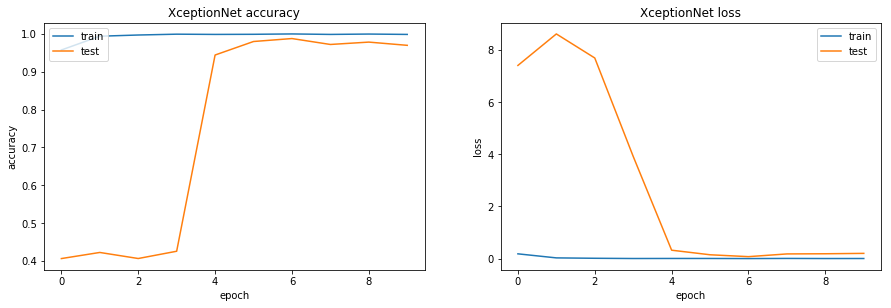

In [18]:
plot_accuracy_and_loss(history)

## Notes:

### If the train accuracy curve presents a stable trend and tends to converge smoothly, while the test accuracy curve oscilliates heavily and tends to be unstable, that indicates it is overfitting

- should train with more data
- apply regularization (like l2)
- or train again with lower learning rate

# Save Model Weights And Configuration

In [16]:
# save model architecture
model_json = model.to_json()
open('xception_model.json', 'w').write(model_json)

# save model's learned weights
model.save_weights('image_classifier_xception.h5', overwrite=True)